# Matt Scheffel
# DS 6040 HW 3

Honor Pledge: I have neither given nor received any aid on this assignment.

# Part 1: Changepoint detection and samplers (50 points)

With the above information, complete the Gibbs sampler in the accompanying notebook. You should only need to complete the update steps for the μ and λ (called lambdap in the notebook) parameters. Run the Gibbs sampler, plot the posterior densities and calculate the EAP estimates with 95% (equal tailed) credible intervals for μ and λ. Provide the top 5 most probable values of k. Then do the the following:

(a) Describe your findings. What do these EAP and credible intervals imply? And what was the most likely year of the changepoint?

(b) Why is an EAP or credible interval not necessarily the most appropriate thing to report for the year of the changepoint?

In [117]:
from scipy.stats import gamma, norm, poisson, multinomial
from scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mpmath as mp
mp.dps = 100

In [118]:
#Import dataset
coal_dat = pd.read_csv("coaldisasters-ds6040.csv")

In [119]:
coal_dat

,Year,Count
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1855,0
...,...,...
107,1958,0
108,1959,0
109,1960,1
110,1961,0


<AxesSubplot:>

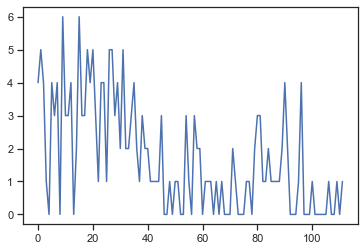

In [120]:
coal_dat['Count'].plot()

In [121]:
class CoalDisasterModel():
    def __init__(self, data, a_mu, b_mu, a_lambda, b_lambda, start_mu = 5, start_lambda = .1, start_k = 64, iter_num = 1000, burnin = 500):
        
        #Read in data and priors, and make them contained class variables
        self.data = data
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.a_lambda = a_lambda
        self.b_lambda = b_lambda
        self.iter_num = iter_num
        self.burnin = burnin
        #Initalize sampling containers
        self.mu = np.zeros(iter_num+burnin+1)
        self.lambdap = np.zeros(iter_num+burnin+1)
        self.k = np.zeros(iter_num+burnin+1)
        
        #Put in starting values
        self.mu[0] = start_mu
        self.lambdap[0] = start_lambda
        self.k[0] = start_k
        
        
        for i in np.arange(iter_num+burnin):
            if i % 100 == 0:
                print("Iteration " + str(i))
            
            
            # This is where you modify the sampler
            self.mu[i+1] = gamma.rvs(a_mu + np.sum(data[0:int(self.k[i])]), scale=1 / (self.k[i] + b_mu))
            self.lambdap[i+1] = gamma.rvs(a_lambda + np.sum(data[int(self.k[i]):]), scale=1 / (len(data) - self.k[i] + b_lambda))
            
            # ------------------This is the changepoint update block 
            likelihood_list = [] #Initialize an empty list
            
            # Iterate from 0 to the length of the data (the last timepoint cannot be the changepoint)
            for k_hat in range(len(data)):
                # Probabilities get very small, so I am using the mp package to get arbitrarily fine-grained precision.
                # I am also computing the probabilities in log form because summing log probabilities is much easier (from a precision standpoint) than multiplying regular probabilities.
                # This is likely overkill here
                temp = mp.mpf(np.sum(np.log(poisson.pmf(data[0:k_hat], self.mu[i+1]))) + np.sum(np.log(poisson.pmf(data[k_hat:], self.lambdap[i+1]))))
                likelihood_list.append(temp)
            
            # Convert likelihood_list to probabilities (with arbitrary precision) and normalize
            k_probs = [mp.exp(x) for x in likelihood_list]
            k_probs = np.asarray(k_probs).astype('float64')
            
            # Ensure the probabilities sum to 1 and avoid potential NaN values in k_probs due to floating-point precision
            if np.sum(k_probs) != 1.0 or np.isnan(np.sum(k_probs)):
                # If the probabilities don't sum to 1 or contain NaN values, set all probabilities to be equal
                k_probs = np.ones(len(k_probs)) / len(k_probs)
            
            # Finally, sample from the multinomial distribution
            self.k[i+1] = np.where(multinomial.rvs(n=1, p=k_probs) == 1)[0][0]

            #------------------End changepoint block
            
    def plot_posteriors(self):
        f, axs = plt.subplots(3,2, figsize = (15, 7))
        f.tight_layout(pad = 3)
        sns.kdeplot(self.mu[self.burnin:],ax =axs[0,0])
        axs[0,0].set_xlabel(r'Posterior $\mu$')
        axs[0,0].set_ylabel('Probability Density')
        sns.kdeplot(self.lambdap[self.burnin:], ax =axs[1,0])
        axs[1,0].set_xlabel(r'Posterior $\lambda$')
        axs[1,0].set_ylabel('Probability Density')
        axs[2,0].hist(self.k[self.burnin:], bins = 112)
        axs[2,0].set_xlabel(r'Posterior k')
        axs[2,0].set_ylabel('Frequency')
        axs[0,1].plot(np.arange(self.iter_num+self.burnin+1),self.mu, '-')
        axs[0,1].set_xlabel('')
        axs[0,1].set_ylabel(r'Posterior $\mu$')
        axs[1,1].plot(np.arange(self.iter_num+self.burnin+1),self.lambdap,'-')
        axs[1,1].set_xlabel('')
        axs[1,1].set_ylabel(r'Posterior $\lambda$')
        axs[2,1].plot(np.arange(self.iter_num+self.burnin+1),self.k,'-')
        axs[2,1].set_xlabel('Iteration')
        axs[2,1].set_ylabel('Posterior k')
    
    def get_rate_estimates(self):
        to_return =pd.DataFrame(columns = ['Posterior EAP', 'Posterior Cred Interval Lower', 'Posterior Cred Interval Upper'])
        to_return.loc[r'mu', 'Posterior EAP'] = self.mu[self.burnin:].mean()
        to_return.loc[r'lambda', 'Posterior EAP'] = self.lambdap[self.burnin:].mean()
        to_return.loc[r'mu', 'Posterior Cred Interval Lower'] = np.quantile(self.mu[self.burnin:],.025)
        to_return.loc[r'lambda', 'Posterior Cred Interval Lower'] = np.quantile(self.lambdap[self.burnin:],.025)
        to_return.loc[r'mu', 'Posterior Cred Interval Upper'] = np.quantile(self.mu[self.burnin:],.975)
        to_return.loc[r'lambda', 'Posterior Cred Interval Upper'] = np.quantile(self.lambdap[self.burnin:],.975)
        return to_return
    
    def get_k_probs(self):
        freq = np.bincount(abs(self.k.astype('int'))[self.burnin:])
        ii = np.nonzero(freq)[0]
        freq = np.vstack((ii,freq[ii])).T
        freq = freq.astype("float16")
        freq[:,1] = freq[:,1]/(freq[:,1].sum())
        freq = pd.DataFrame(freq, columns=['k', 'Probability of k'])
        
        return freq

In [82]:
count_data = coal_dat['Count'].to_numpy()
test = CoalDisasterModel(count_data, 1, 1, 1, 1)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400


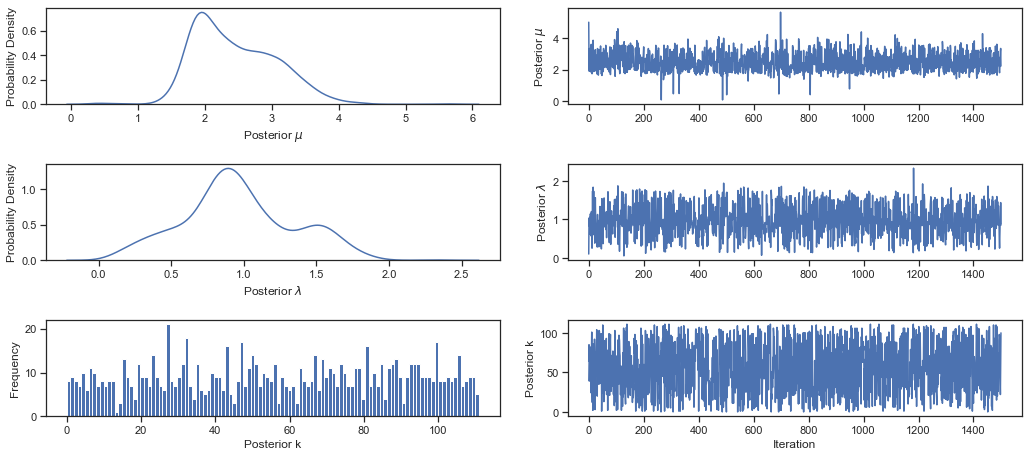

In [83]:
test.plot_posteriors()

In [84]:
test.get_rate_estimates()

,Posterior EAP,Posterior Cred Interval Lower,Posterior Cred Interval Upper
mu,2.458481,1.586641,3.718927
lambda,0.963927,0.238079,1.7047


# Top 5 Most Probable Values of k:

In [129]:
most_prob_k = test.get_k_probs()
most_prob_k.sort_values(by = ["Probability of k"], ascending = False).head(5)
most_prob_k['year'] = [int(y + 1851) for y in most_prob_k['k']]
most_prob_k.sort_values(by = ["Probability of k"], ascending = False).head(5)

,k,Probability of k,year
27,27.0,0.020981,1878
32,32.0,0.017975,1883
47,47.0,0.016983,1898
100,100.0,0.016983,1951
81,81.0,0.015991,1932


# (a) Describe your findings. What do these EAP and credible intervals imply? And what was the most likely year of the changepoint?

Considering the assumption of a changepoint for the counts of coal mining disasters (k = 27), we can compare the posterior Expected A Posteriori (EAP) values of mu and lambda with the initial count plot. In the count plot, we notice that leading up to around k = 30, the mean of disasters was generally higher than after k = 30. By analyzing our EAP estimates and credible intervals, we observe a slight overlap between the two intervals (from approx. ~1.5 to ~1.7). This suggests the presence of a noticeable change in the behavior of coal mining disasters, indicating the existence of two separate distributions.

Interestingly, the top 3 most probable k values (27, 32, and 47) as shown above closely align with the patterns initially observed from the counts plots andf are grouped relatively close together, but the next 2 most probable seem a bit more random.

Accoridng to the k probability results, the most likely year of the changepoint was 1878. (1883 also seems to be a likely candidate for the year of the changepoint.)

# (b) Why is an EAP or credible interval not necessarily the most appropriate thing to report for the year of the changepoint?

The EAP represents the expected value, but it may not be the most suitable measure in this context because our primary interest lies in understanding the overall distribution shape and identifying the moment of change. While the EAP analysis is valuable for interpreting the nature of Bayesian statistics, it is essential to acknowledge the inherent flexibility of Bayesian methods. Alternatively, this analysis could have been conducted using Maximum A Posteriori (MAP) estimation, leading to potentially different conclusions. Also, altering the prior information could significantly impact the EAP and credible intervals, emphasizing the vulnerability of the EAP approach to manipulation.

# Part 2: Bayesian Logistic Regression with PyMC3

1. Load the data from whitewine-training-ds6040.csv and create a new 0/1 quality variable, where the new quality of the wine is 0 if the wine received a C or F, and 1 if the wine received an A.

In [91]:
wine_2 = pd.read_csv("whitewine-training-ds6040.csv")
wine_2.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C


In [110]:
new_wine = {'C':0, 
               'F':0, 
               'A':1}
wine_2["wine_class"] = wine_2["wine_quality"].map(new_wine)
wine_2.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,wine_quality,wine_class
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C,0
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C,0
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C,0
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0


In [111]:
wine_2.columns = [x.replace('.','_') if '.' in x else x for x in wine_2.columns]
wine_2.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,wine_quality,wine_class
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C,0
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C,0
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C,0
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0


2. Using the notebook BayesLogisticRegression.ipynb as an implementation guide, fit two logistic regression models chosen as follows (Note: you won’t be penalized if you, for example, did something in the HW2 incorrectly and are presenting models I don’t expect):

    • Choose the set of 3 variables that in HW2 gave you the best classification rate overall within the training data.

    • Choose the set of 3 variables that gave you the best classification rates of A grade wines in the training dataset (you will have to look back into HW2, and make some slight modifications to your code to obtain this information. Hint, you need to use the cross-tab information).

Once you have fit your two models, plot both traceplots and forestplots using code from the BayesLogisticRegression notebook.

Discuss your findings. Note that I am not asking you to calculate miss-classification rates, rather to examine your parameter distributions and explain what those estimates mean, and how they compare to one another. Don’t forget to interpret the intercept as well.

In [94]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the set of 3 variables that in HW2 gave you the best classification rate overall within the training data.

In [95]:
###The following code is heavily based or taken directly from: https://www.kaggle.com/billbasener/pymc3-bayesian-logistic-regression-classification

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Best set of 3 variables from HW 2: ['volatile.acidity', 'density', 'alcohol', 'wine_quality']
0.4877906976744186

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alcohol, density, volatile_acidity, Intercept]


/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
/var/folders/9s/pz872p91741110p_4gz6llzc0000gn/T/ipykernel_94255/845273577.py:11: DeprecationWarning: The function `forestplot` from PyMC3 i

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.907,0.146,-4.164,-3.627,0.003,0.002,2268.0,2714.0,1.0
volatile_acidity,-0.352,0.125,-0.588,-0.124,0.003,0.002,2454.0,2420.0,1.0
density,0.220,0.153,-0.069,0.501,0.003,0.002,2017.0,1833.0,1.0
alcohol,1.134,0.167,0.829,1.449,0.004,0.003,1583.0,1695.0,1.0


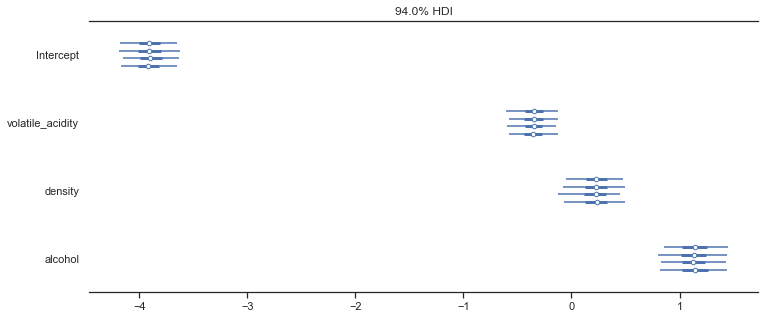

In [96]:
#This is the general form for the logistic. You will need to change the model formula to match the white wine data.
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'wine_class ~ volatile_acidity + density + alcohol', 
                            data = wine_2, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1000)


#You can obtain forest plots with:
pm.plots.forestplot(trace, figsize = (12,5))

#You can get a table of summary statistics out using:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/9s/pz872p91741110p_4gz6llzc0000gn/T/ipykernel_94255/2855945336.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(traces[-retain:],
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using t

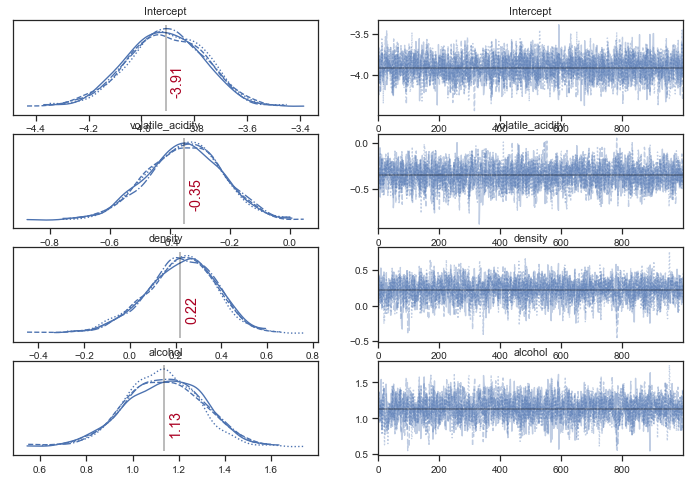

In [97]:
plot_traces(trace)

# Choose the set of 3 variables that gave you the best classification rates of A grade wines in the training dataset (you will have to look back into HW2, and make some slight modifications to your code to obtain this information. Hint, you need to use the cross-tab information).

In [103]:
# rerun LDA from HW2

In [104]:
# import libraries

import itertools
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "ticks")
from itertools import combinations

In [105]:
# LDA Class (code given in example from Professor)

class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

In [106]:
# find best wines from Class A

wine_A = pd.read_csv("whitewine-training-ds6040.csv")
e_rates_list = []

for i in itertools.combinations(wine_A.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    flat_priors_lda = LDA(wine_A[combination], 'wine_quality')
    A_error = flat_priors_lda.misclass_xtabs()["A"][0] / sum(flat_priors_lda.misclass_xtabs()["A"])
    e_rates_list.append([",".join(combination[:-1]), A_error])

e_rates_df = pd.DataFrame(e_rates_list)

e_rates_df.columns = ["combinations",\
                                       "class_A_correct"]

In [107]:
e_rates_df.sort_values("class_A_correct", ascending = False)

,combinations,class_A_correct
140,"chlorides,density,sulphates",0.72
79,"volatile.acidity,pH,alcohol",0.72
159,"total.sulfur.dioxide,pH,alcohol",0.72
135,"chlorides,total.sulfur.dioxide,density",0.72
107,"citric.acid,pH,alcohol",0.72
...,...,...
97,"citric.acid,free.sulfur.dioxide,sulphates",0.30
47,"volatile.acidity,citric.acid,free.sulfur.dioxide",0.30
7,"fixed.acidity,volatile.acidity,sulphates",0.29
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.28


# We get that chlorides, density, and sulphates are the best combination from the Class A wines.

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sulphates, density, chlorides, Intercept]


/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
/var/folders/9s/pz872p91741110p_4gz6llzc0000gn/T/ipykernel_94255/345171114.py:10: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.plots.forestplot(trace2, figsize = (12,5))
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.744,0.138,-4.009,-3.494,0.002,0.002,3088.0,2855.0,1.0
chlorides,-0.523,0.225,-0.946,-0.117,0.004,0.003,3004.0,2262.0,1.0
density,-0.620,0.142,-0.883,-0.350,0.003,0.002,2643.0,2337.0,1.0
sulphates,0.038,0.096,-0.146,0.219,0.002,0.001,3357.0,2313.0,1.0


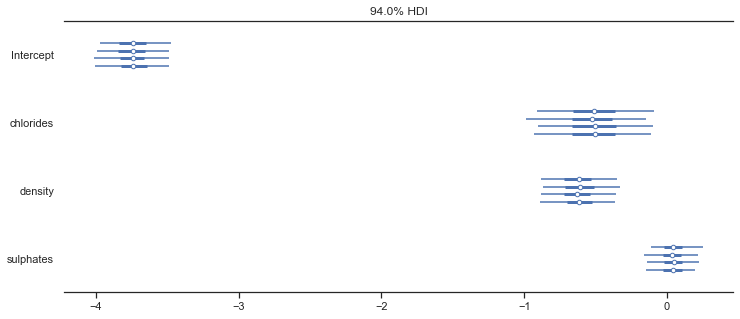

In [75]:
with pm.Model() as model2:
    pm.glm.GLM.from_formula(formula = 'wine_class ~ chlorides + density + sulphates', 
                            data = wine_data, 
                            family = pm.glm.families.Binomial())

    trace2 = pm.sample(1000)


#You can obtain forest plots with:
pm.plots.forestplot(trace2, figsize = (12,5))

#You can get a table of summary statistics out using:
pm.summary(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/9s/pz872p91741110p_4gz6llzc0000gn/T/ipykernel_94255/2855945336.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(traces[-retain:],
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using t

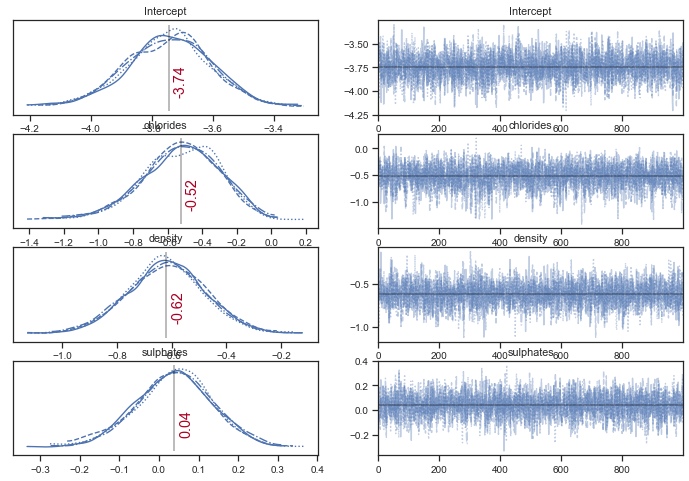

In [76]:
plot_traces(trace2)

In [108]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.907,0.146,-4.164,-3.627,0.003,0.002,2268.0,2714.0,1.0
volatile_acidity,-0.352,0.125,-0.588,-0.124,0.003,0.002,2454.0,2420.0,1.0
density,0.220,0.153,-0.069,0.501,0.003,0.002,2017.0,1833.0,1.0
alcohol,1.134,0.167,0.829,1.449,0.004,0.003,1583.0,1695.0,1.0


In [109]:
pm.summary(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/matthewscheffel/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.744,0.138,-4.009,-3.494,0.002,0.002,3088.0,2855.0,1.0
chlorides,-0.523,0.225,-0.946,-0.117,0.004,0.003,3004.0,2262.0,1.0
density,-0.620,0.142,-0.883,-0.350,0.003,0.002,2643.0,2337.0,1.0
sulphates,0.038,0.096,-0.146,0.219,0.002,0.001,3357.0,2313.0,1.0


# Discuss your findings. Note that I am not asking you to calculate miss-classification rates, rather to examine your parameter distributions and explain what those estimates mean, and how they compare to one another. Don’t forget to interpret the intercept as well.

The summaries reveal that both the first and second models have negative intercepts. This implies that when volatile_acidity, density, and alcohol are set to 0 in the first model, the prediction will tend towards 0, corresponding to wine types C and F in the context of the problem. This reasoning aligns with our understanding that a wine lacking density, alcohol, and volatile acidity is unlikely to be of high quality. The same principle applies to the second model, where a wine with no chlorides, density, and sulphates will not be classified as a good wine.

We see from the analysis of the first model that notably the predictor "volatile_acidity" displayed a negative slope. This indicates that as the volatile acidity in a wine increases, the likelihood of it being classified as a bad wine also rises. Regarding the "density" predictor, the mean was positive, but the Highest Density Interval (HDI) contained 0. On average, higher density in a wine seems to be associated with a higher probability of being classified as type A. However, since the interval contains 0, further investigation is required to establish this relationship more definitively. For the "alcohol" parameter, the mean was positive, and the HDI did not include 0. Consequently, we can  assert that the more alcohol a wine contains, the better it is likely to be classified as wine type A. However, it's essential to approach the conclusion cautiously and not interpret it as an indication that increasing alcohol content will always lead to a better wine. Most likely the alcohol volume would reach a "tippiing point" or level that would make the wine quality worse if the alcohol content was too high.

The second model, which focused on identifying the best predictors for distinguishing the finest wines rather than the overall wine classifications, identified three distinct predictors: chlorides, density, and sulphates. Notably, the density predictor was the only one that overlapped with the first model. In this case, density displayed a negative slope, and the HDI did not contain 0. This suggests that denser wines are more likely to be classified as lower quality wines. This aligns well with real-world intuition, since a wine's excessive density might result in a less smooth-tasting wine experience. Similarly, chlorides exhibited behavior similar to density, with the interpretation being akin to more chlorides in a wine type being associated with a higher likelihood of it being classified as a bad (C or F) wine. On the other hand, the only predictor with a positive slope in the second model was sulphates. However, it's important to note that the HDI interval contained 0, implying that sulphates may not significantly influence the prediction of wine quality according to this model. Despite knowing that sulphates are beneficial for better tasting wine and extended shelf life in the real world, the model's results don't definitively support the notion that more sulphates lead to better wine quality.